In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import numpy as np
import pandas as pd
import requests
import copy
import time
import os
import sys
from datetime import datetime
import warnings

In [3]:
import talib

In [4]:
if '1.5.3' != pd.__version__:
    raise Exception("Please use pandas 1.5.3, as 'FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.'")

In [5]:
# Todo: PC requires random, this should not be
import random

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-04-21 09:13:05.199546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 09:13:05.279111: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 09:13:05.301206: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-21 09:13:05.731056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


---
# Add custom import path for DataStreamCreator, IndicatorCalculator and PredictionCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [7]:
# Create the import directories for the DataStreamCreator, the IndicatorCalculator and the PredictionCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

pc_dir = '/content/CryptoCrystalBall/SignalGenerator/scripts'
print(f"pc_dir: {pc_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)
sys.path.insert(0, pc_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator
pc_dir: /content/CryptoCrystalBall/SignalGenerator/scripts


In [8]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator
from PredictionCalculator import PredictionCalculator

---
# Define all the parameters and variables

In [9]:
MODEL_PATH = "/content/bigdata/chk/FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB/cp_daily_valid_06_end/model.h5"

In [10]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator

# For this ML architecture, the X_BLOCK_LENGHT has to be a member of 2**n, otherwise the feature pyramid cannot be built correctly 

X_BLOCK_LENGHT = 128

In [11]:
# A fixed number of features is used
FEATURES = 149

In [12]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [13]:
INDICATOR_MINMAX_PERIOD = 28

In [14]:
# The TaLib indicators need some time to settle to stable, reproducible values (Todo imporant: Check which need this, why, and how long (determinisitcally) this period is)
RING_IN_PERIOD = 3 * LONGSPAN
RING_IN_PERIOD

150

In [15]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": False # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

In [16]:
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 60
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

# PredictionCalculator

In [17]:
with tf.device("CPU:0"):
  from PredictionCalculator import PredictionCalculator
  pc = PredictionCalculator(MODEL_PATH)

2023-04-21 09:13:08.087844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 09:13:08.115718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 09:13:08.115837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 09:13:08.116313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator
Model: "FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_1 (InputLayer)                                             [(None, 128, 116)]                          0                       []                                                                
                                                                                                                                                                                                        
 UnitNormalizatio

# Getter stuff

In [18]:
def GetCommandList(isin):
  # The requests have to be done in this weird order, you cannot get the chart directly
  
  command_list = [
      ["GET", f"https://www.justetf.com/at/etf-profile.html?isin={isin}", None],
      ["GET", f"https://www.justetf.com/at/etf-profile.html?0-1.1-&isin={isin}&_wicket=1", None], # 1-year chart, has to be fetched in the beginning
      ["GET", f"https://www.justetf.com/at/etf-profile.html?0-1.0-chartPanel-chart-content-dates-ptl_max=&isin={isin}&_wicket=1", None], # Full time chart
      [
      "POST",
      f"https://www.justetf.com/at/etf-profile.html?0-1.0-chartPanel-chart-content-optionsPanel-selectContainer-valueType&isin={isin}&_wicket=1",
        {
        "chartPanel:chart:content:optionsPanel:selectContainer:valueType": "market_value"
        }
      ]
      ]

  return command_list

In [19]:
def commandListExecutor(commandList):
  i = 0

  while i < len(commandList):
    command = commandList[i][0]
    url = commandList[i][1]
    body = commandList[i][2]

    i += 1
    
    yield command, url, body

In [20]:
def GetHistoricalData(isin):  
  # Use a session to keep track of cookies
  s = requests.Session()

  # Store the responses
  htmlResponses = []

  # A cookie dict to keep track of the client state
  cookieDict = {'AWSALB': None,
                'AWSALBCORS': None,
                'JSESSIONID': None,
                'locale_': None
                }

  # Headers required for requests
  # https://stackoverflow.com/questions/59330739/scrape-xml-response-from-ajax-request-with-python
  # Not all of these headers may be necessary
  headers = {
      'accept': "application/xml, text/xml, */*; q=0.01",
      'x-requested-with': "XMLHttpRequest",
      'Wicket-Ajax-BaseURL': f"at/etf-profile.html?isin={isin}",
      'Wicket-Ajax': "true",
      'Connection': "keep-alive",
      'TE': 'trailers'
  }

  # Use a generator to read the commando list
  commandList = GetCommandList(isin)
  commandExecutor = commandListExecutor(commandList)

  for i,(c,u,b) in enumerate(commandExecutor):
    # logger.debug(i)
    # logger.debug(c)
    # logger.debug(u)
    # logger.debug(b)

    # Get request
    if "GET" == c:  
      if 0 < i:
        r = s.get(u, cookies=cookieDict, headers=headers)
      else:
        r = s.get(u, cookies=cookieDict)
    elif "POST" == c:
      # Wait a little bit, as this request would require user interaction in the real homepage
      waitTimeTillPost = random.randrange(100,200)/10.0
      logging.info(f"Waiting {waitTimeTillPost} seconds until sending post command, to avoid attracting attention..")
      time.sleep(waitTimeTillPost)
      
      r = s.post(u, cookies=cookieDict, headers=headers, data=b)
    
    logger.debug(r.status_code)
    logger.debug(len(r.text))

    # Store the reponse
    htmlResponses.append(r.text)

    # Keep track of cookies
    responseCookies = dict(r.cookies)

    # Always set the AWS tokens
    cookieDict['AWSALB'] = responseCookies['AWSALB']
    cookieDict['AWSALBCORS'] = responseCookies['AWSALBCORS']

    # The JSESSIONID has to be set only once
    if cookieDict['JSESSIONID'] is None:
      cookieDict['JSESSIONID'] = responseCookies['JSESSIONID']

    # The locale_ has to be set only once
    if cookieDict['locale_'] is None:
      cookieDict['locale_'] = responseCookies['locale_']

    logger.debug("\n")

  return htmlResponses[-1]

# Extract the chart data

In [21]:
def ExtractChartData(htmlResponseString):
  # Get the CDATA container
  SPLIT_STRING_BEGINNING = "/*<![CDATA[*/"
  SPLIT_STRING_END = "/*]]]]><![CDATA[>*/"

  # The chart data is in the last CDATA container
  CDATA_string = htmlResponseString.split(SPLIT_STRING_BEGINNING)[-1]
  CDATA_string = CDATA_string.split(SPLIT_STRING_END)[0]

  # Extract the data from the CDATA_string
  SPLIT_STRING_BEGINNING = "data: ["
  SPLIT_STRING_END = "}"

  # Get the actual data
  data_string = CDATA_string.split(SPLIT_STRING_BEGINNING)[1]
  data_string = data_string.split(SPLIT_STRING_END)[0]

  # Clean up the js stuff
  data_string = data_string.replace("Date.UTC(", "")
  data_string = data_string.replace(")", "")
  data_string = data_string.replace("]", "") 

  # Extract the data points
  data_list = []

  data_points_raw = data_string.split("[")

  for dpr in data_points_raw:
    if 0 == len(dpr):
      continue
    
    data_point_values = dpr.split(",")

    year = int(data_point_values[0])
    month = int(data_point_values[1])+1 # Starts at 0! (but day does not????)
    day = int(data_point_values[2])

    value = float(data_point_values[3])

    data_list.append([
        datetime(year=year, month=month, day=day), value
        ]
    )

    # Convert it into a DataFrame
    data_DF = pd.DataFrame(data_list)
    data_DF.set_index(0, inplace=True)
    data_DF.sort_index(inplace=True)
    data_DF.index.names = ['date']
    data_DF.columns = ["price"]
    
  return data_DF

In [22]:
isins_df = pd.read_csv("/content/CryptoCrystalBall/Data/ETF/ISIN_List_Flatex.csv", sep="\t")
isins_df.dropna(inplace=True)
isins_df

,Name,Emittent,ISIN
0,"AIRLINES, HOTELS, CRUISE LINES ETF",HANetf Management Ltd.,IE00BMFNW783
1,AIS INDEX US CORP SRI,Amundi Luxembourg S.A.,LU2297533809
2,AIS INDEX US CORP SRI,Amundi Luxembourg S.A.,LU1806495575
3,AIS-AM.E.L.S.F.EOC,Amundi Luxembourg S.A.,LU1681041544
4,AIS-AM.GL.EM.B.M.I.DR DLC,Amundi Luxembourg S.A.,LU1681041205
...,...,...,...
1263,XTRACKERS SWITZERLAND ETF,DWS Investment S.A.,LU0274221281
1264,XTRACKERS USD CORPORATE BOND ETF,DWS Investment S.A.,IE00BZ036J45
1265,XTRACKERS USD CORPORATE BOND ETF,DWS Investment S.A.,IE00BZ036H21
1266,XTRACKERS USD HIGH YLD CORPORATE BD ETF,DWS Investment S.A.,IE00BDR5HM97


In [23]:
SAVE_PATH = "/content/CryptoCrystalBall/Data/etfWithPrediction"

In [24]:
n=1

for i in isins_df.index:
  try:
    isin = isins_df.loc[i,"ISIN"]
    #isin = "CH0454664027" # ETH USD
    logging.info(f"\nGetting {n} of {len(isins_df.index)}, ISIN: {isin}")
    n+=1

    # Get the data
    justetfRawString = GetHistoricalData(isin)
    tickDF = ExtractChartData(justetfRawString)
    
    # Convert the DatetimeIndex into unix timestamps
    # https://stackoverflow.com/a/15204235/21648425
    tickDF.index = tickDF.index.astype(np.int64) // 10**9
    
    # Extend to a 'standard-formatted' tick DF
    tickDF.index.names = ['startsAt']
    tickDF.columns = ['open']
    tickDF['high'] = tickDF['open']
    tickDF['low'] = tickDF['open']
    tickDF['close'] = tickDF['open']
    tickDF['volume'] = 0.0
    tickDF['quoteVolume'] = 0.0
    
    # The query gets only the values until the previous day, so the "current" day has to be appended
    # It is then dispose by the DataStreamCreator, as it may be still changing
    lastRow = tickDF.iloc[-1]
    lastRow.name += 1*24*60*60 # Add a day
    with pd.option_context('mode.chained_assignment', None):
        lastRow[:] = -1
    
    # https://stackoverflow.com/a/66504876/21648425
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        tickDF = tickDF.append(lastRow)
        
    # Predict future gain and derivation
    with tf.device("CPU:0"):
      p = pc.predict(tickDF)

    #plt.plot(tickDF)

    # Save the data
    csv_path = os.path.join(SAVE_PATH, f"{isin.replace(' ','')}.csv")
    tickDF.to_csv(csv_path)
    break
  except KeyboardInterrupt:
    raise
  # except Exception as ex:
  #   logging.error(f"Exception on {isin}: {str(ex)}")

  # Wait a little bit until the next isin
  #waitTimeTillNextIsin = random.randrange(300,500)/10.0
  #logging.info(f"Waiting {waitTimeTillNextIsin} seconds until getting the next isin..")
  #time.sleep(waitTimeTillNextIsin)

INFO:root:
Getting 1 of 1268, ISIN: IE00BMFNW783 
INFO:root:Waiting 11.8 seconds until sending post command, to avoid attracting attention..
INFO:root:File 'tmpviitmtgs' loaded, 0 left


X_blocks.shape after crop: (28, 128, 116)


In [25]:
p

{'p_future': array([0.0043976 , 0.00449752, 0.00440827, 0.00457386, 0.00453924,
        0.00446156, 0.00435803, 0.00446086, 0.00442579, 0.00446307,
        0.0044636 , 0.00470993, 0.00456952, 0.0045645 , 0.00448603,
        0.00475152, 0.00452637, 0.004552  , 0.00433391, 0.00438817,
        0.0041266 , 0.00424656, 0.00410399, 0.00414659, 0.00404215,
        0.00400549, 0.00383645, 0.00375749], dtype=float32),
 'p_future_derivation': array([ 8.4317889e-04,  7.5329310e-04,  6.2065985e-04,  7.0015050e-04,
         6.8664498e-04,  7.2507671e-04,  6.4361497e-04,  6.5616495e-04,
         6.0134934e-04,  4.3576339e-04,  3.1144585e-04,  4.6134429e-04,
         3.6181370e-04,  4.9051491e-04,  3.1377608e-04,  4.1439856e-04,
         2.8633024e-04,  2.7954509e-04,  4.6717294e-05,  8.3792926e-05,
        -3.3641554e-05, -5.5599638e-05, -1.4452104e-04, -1.2396694e-04,
        -1.7702603e-04, -2.3415821e-04, -3.2868440e-04, -5.7275651e-04],
       dtype=float32)}

In [26]:
import matplotlib.pyplot as plt

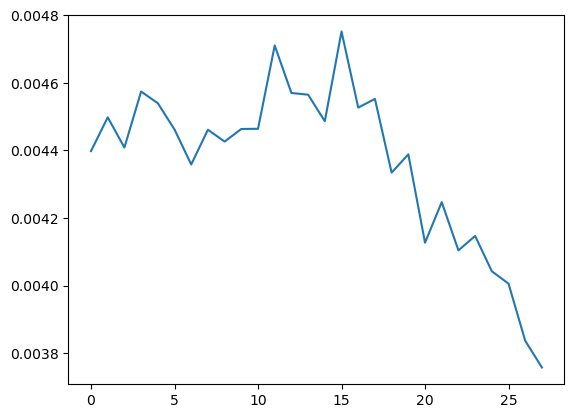

In [27]:
plt.plot(p['p_future'])

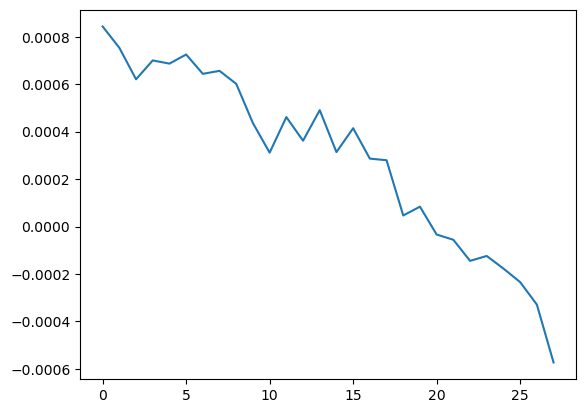

In [28]:
plt.plot(p['p_future_derivation'])

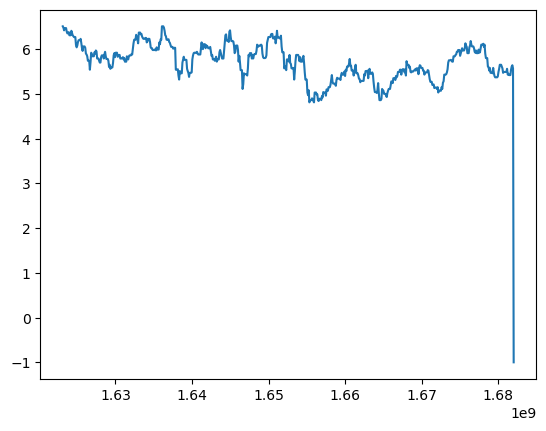

In [29]:
plt.plot(tickDF['open'])

# The "awesome" trading strategy
From test --> Working in both!!

TradeAllV2(tbls_dict, 0.0030, 0.025, 0.0075, 0.01, 2*30*24*60*60)

In [30]:
ENTR_THR = 0.003
ENTR_THR2 = 0.025

EXIT_THR = 0.0075
EXIT_THR2 = 0.01

In [31]:
GAIN_TIMESPAN = 60

In [32]:
FIRST_INDICATOR_NAME = "p_future_gain"
SECOND_INDICATOR_NAME = "p_future_gain_derivation"
THIRD_INDICATOR_NAME = "max_past_gain"

In [33]:
signalsTmpDF = copy.deepcopy(tickDF)
signalsTmpDF

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1623110400,6.51,6.51,6.51,6.51,0.0,0.0
1623196800,6.48,6.48,6.48,6.48,0.0,0.0
1623283200,6.42,6.42,6.42,6.42,0.0,0.0
1623369600,6.47,6.47,6.47,6.47,0.0,0.0
1623456000,6.47,6.47,6.47,6.47,0.0,0.0
...,...,...,...,...,...,...
1681689600,5.54,5.54,5.54,5.54,0.0,0.0
1681776000,5.61,5.61,5.61,5.61,0.0,0.0
1681862400,5.64,5.64,5.64,5.64,0.0,0.0


In [34]:
# For each timestep, calculate the highest possible gain within the timespan `gain_timespan`, once into the past and once into the future
def AddMaxPastGain(tblIn, gain_timespan):
  __INDICATOR_NAME = "max_past_gain"

  # tblWork = copy.deepcopy(tblIn)
  tblWork = tblIn

    # Set all to 0
  tblWork.loc[:, __INDICATOR_NAME] = 0.0

  for i in range(1, tblWork.shape[0]-1):
      # Get the end index for the past
      past_index = np.max([0, i-gain_timespan])

      # Get the slice for max gain lookup from the DF
      past_slice = tblWork.iloc[past_index:i].loc[:,'open'].values      

      # Get the 'current' price
      current_price = tblWork.iloc[i].loc['open']

      if 0 == past_slice.shape[0]:
          continue

      # For the past, the min value has to be found, because in the past you wanted to buy lower
      min_past_value = np.min(past_slice)

      if 0.0 == min_past_value:
          continue

      max_past_gain = (current_price / min_past_value) - 1.0

      # Calculate the gain
      if 0.0 != min_past_value:
          tblWork.loc[tblWork.index[i], __INDICATOR_NAME] = max_past_gain

  return tblWork

# _tblWithDebug = AddMaxPastGain(_tbl, 60)

In [35]:
def AddHistoricalMinMax(tblIn, featureName):
  values = tblIn.loc[:,featureName].values

  # # Shift the values to get on the historical max and not include the current value
  # values_shifted = np.empty(values.shape)
  # values_shifted[:] = np.nan
  # values_shifted[1:] = values[:-1]

  # Do not Shift the values to get on the historical max, to include the current value
  values_shifted = values

  valuesMIN = talib.MIN(values_shifted.astype(float), timeperiod=INDICATOR_MINMAX_PERIOD)
  valuesMAX = talib.MAX(values_shifted.astype(float), timeperiod=INDICATOR_MINMAX_PERIOD)

  tblIn.loc[:, featureName + '_min'] = valuesMIN
  tblIn.loc[:, featureName + '_max'] = valuesMAX

  return tblIn

In [36]:
signalsTmpDF = AddMaxPastGain(signalsTmpDF, 60)
signalsTmpDF = signalsTmpDF.iloc[:-1,:] # Crop the latest (unstable) row
signalsTmpDF = AddHistoricalMinMax(signalsTmpDF, THIRD_INDICATOR_NAME)
signalsTmpDF

/tmp/ipykernel_62/850386805.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tblIn.loc[:, featureName + '_min'] = valuesMIN
/tmp/ipykernel_62/850386805.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tblIn.loc[:, featureName + '_max'] = valuesMAX


,open,high,low,close,volume,quoteVolume,max_past_gain,max_past_gain_min,max_past_gain_max
startsAt,,,,,,,,,
1623110400,6.51,6.51,6.51,6.51,0.0,0.0,0.000000,NaN,NaN
1623196800,6.48,6.48,6.48,6.48,0.0,0.0,-0.004608,NaN,NaN
1623283200,6.42,6.42,6.42,6.42,0.0,0.0,-0.009259,NaN,NaN
1623369600,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN
1623456000,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1681603200,5.42,5.42,5.42,5.42,0.0,0.0,0.009311,-0.010989,0.052142
1681689600,5.54,5.54,5.54,5.54,0.0,0.0,0.031657,-0.010989,0.052142
1681776000,5.61,5.61,5.61,5.61,0.0,0.0,0.044693,-0.010989,0.052142


In [37]:
p_future_gain_array = np.zeros((signalsTmpDF.shape[0]))
p_future_gain_array[-p['p_future'].shape[0]:] = p['p_future']
p_future_gain_array

p_future_gain_derivation_array = np.zeros((signalsTmpDF.shape[0]))
p_future_gain_derivation_array[-p['p_future_derivation'].shape[0]:] = p['p_future_derivation']
p_future_gain_derivation_array

with pd.option_context('mode.chained_assignment', None):
    signalsTmpDF.loc[:,"p_future_gain"] = p_future_gain_array
    signalsTmpDF.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation_array

signalsTmpDF

,open,high,low,close,volume,quoteVolume,max_past_gain,max_past_gain_min,max_past_gain_max,p_future_gain,p_future_gain_derivation
startsAt,,,,,,,,,,,
1623110400,6.51,6.51,6.51,6.51,0.0,0.0,0.000000,NaN,NaN,0.000000,0.000000
1623196800,6.48,6.48,6.48,6.48,0.0,0.0,-0.004608,NaN,NaN,0.000000,0.000000
1623283200,6.42,6.42,6.42,6.42,0.0,0.0,-0.009259,NaN,NaN,0.000000,0.000000
1623369600,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000
1623456000,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1681603200,5.42,5.42,5.42,5.42,0.0,0.0,0.009311,-0.010989,0.052142,0.004147,-0.000124
1681689600,5.54,5.54,5.54,5.54,0.0,0.0,0.031657,-0.010989,0.052142,0.004042,-0.000177
1681776000,5.61,5.61,5.61,5.61,0.0,0.0,0.044693,-0.010989,0.052142,0.004005,-0.000234


In [38]:
def CalcEntrySignals(tbl, entr_thr, entr_thr2, entr_thr3):

  # Working nicely
  _entr = (tbl.loc[:,f"{FIRST_INDICATOR_NAME}"] >= entr_thr) & (tbl.loc[:,f"{THIRD_INDICATOR_NAME}"] >= entr_thr2)

  tbl['entry_signal'] = _entr

  return tbl

In [39]:
def CalcExitSignals(tbl, exit_thr, exit_thr2):

  # Working nicely 
  _exit = (tbl.loc[:,f"{SECOND_INDICATOR_NAME}"] <= exit_thr) & ((tbl.loc[:,f"{THIRD_INDICATOR_NAME}_max"]/10.0) >= exit_thr2)

  tbl['exit_signal'] = _exit

  return tbl

In [40]:
CalcEntrySignals(signalsTmpDF, ENTR_THR, ENTR_THR2, 0.0)

/tmp/ipykernel_62/915606677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['entry_signal'] = _entr


,open,high,low,close,volume,quoteVolume,max_past_gain,max_past_gain_min,max_past_gain_max,p_future_gain,p_future_gain_derivation,entry_signal
startsAt,,,,,,,,,,,,
1623110400,6.51,6.51,6.51,6.51,0.0,0.0,0.000000,NaN,NaN,0.000000,0.000000,False
1623196800,6.48,6.48,6.48,6.48,0.0,0.0,-0.004608,NaN,NaN,0.000000,0.000000,False
1623283200,6.42,6.42,6.42,6.42,0.0,0.0,-0.009259,NaN,NaN,0.000000,0.000000,False
1623369600,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000,False
1623456000,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1681603200,5.42,5.42,5.42,5.42,0.0,0.0,0.009311,-0.010989,0.052142,0.004147,-0.000124,False
1681689600,5.54,5.54,5.54,5.54,0.0,0.0,0.031657,-0.010989,0.052142,0.004042,-0.000177,True
1681776000,5.61,5.61,5.61,5.61,0.0,0.0,0.044693,-0.010989,0.052142,0.004005,-0.000234,True


In [41]:
CalcExitSignals(signalsTmpDF, EXIT_THR, EXIT_THR2)

/tmp/ipykernel_62/2791993024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['exit_signal'] = _exit


,open,high,low,close,volume,quoteVolume,max_past_gain,max_past_gain_min,max_past_gain_max,p_future_gain,p_future_gain_derivation,entry_signal,exit_signal
startsAt,,,,,,,,,,,,,
1623110400,6.51,6.51,6.51,6.51,0.0,0.0,0.000000,NaN,NaN,0.000000,0.000000,False,False
1623196800,6.48,6.48,6.48,6.48,0.0,0.0,-0.004608,NaN,NaN,0.000000,0.000000,False,False
1623283200,6.42,6.42,6.42,6.42,0.0,0.0,-0.009259,NaN,NaN,0.000000,0.000000,False,False
1623369600,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000,False,False
1623456000,6.47,6.47,6.47,6.47,0.0,0.0,0.007788,NaN,NaN,0.000000,0.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681603200,5.42,5.42,5.42,5.42,0.0,0.0,0.009311,-0.010989,0.052142,0.004147,-0.000124,False,False
1681689600,5.54,5.54,5.54,5.54,0.0,0.0,0.031657,-0.010989,0.052142,0.004042,-0.000177,True,False
1681776000,5.61,5.61,5.61,5.61,0.0,0.0,0.044693,-0.010989,0.052142,0.004005,-0.000234,True,False


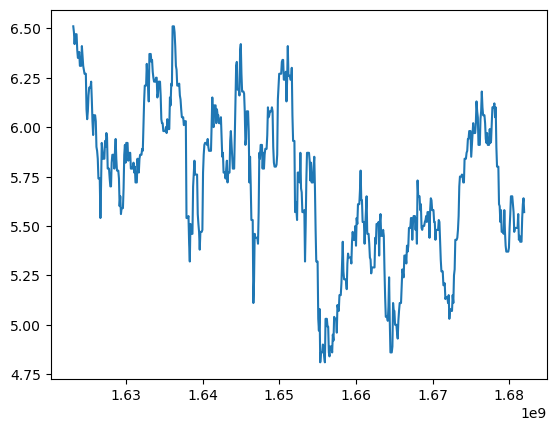

In [49]:
plt.plot(signalsTmpDF["open"])

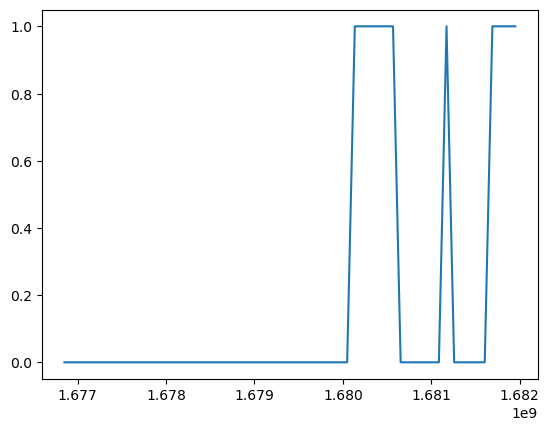

In [48]:
plt.plot(signalsTmpDF.iloc[-60:,:]["entry_signal"])

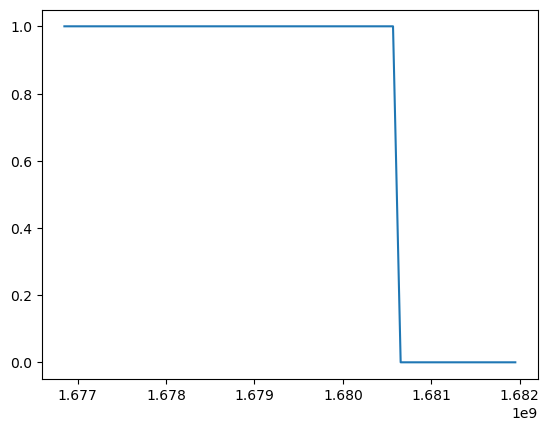

In [47]:
plt.plot(signalsTmpDF.iloc[-60:,:]["exit_signal"])

In [43]:
np.sum(signalsTmpDF["entry_signal"])

11

In [44]:
np.sum(signalsTmpDF["exit_signal"])

505